In [13]:
# CSS TO CENTER THE FIGURES. IGNORE
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Principal Component Analysis

PCA is fundamentally a **dimensionality reduction** algorithm, but it can also be useful as a tool for visualization, for noise filtering, for feature extraction and engineering, and much more.

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(9, 7)})

Lets get some intuition by looking at a 2-dimensional dataset:

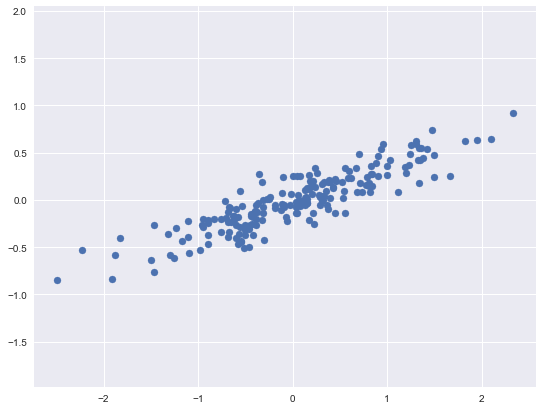

In [15]:
np.random.seed(1)
X = np.dot(np.random.rand(2, 2), np.random.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

If we want compress the data to one dimension:
+ Project over x axis

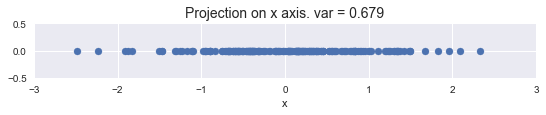

In [16]:
var = np.var(X[:,0])

fig, ax = plt.subplots(figsize=(9,1))
ax.scatter(X[:,0], [0]*X.shape[0])
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-3, 3)
ax.set_xlabel('x')
plt.title(f'Projection on x axis. var = {var:.3}', fontsize=14)
#ax.set_axis_off()
plt.show()

+ project over y axis

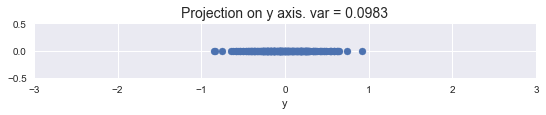

In [17]:
var = np.var(X[:,1])

fig, ax = plt.subplots(figsize=(9,1))
ax.scatter(X[:,1], [0]*X.shape[0])
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-3, 3)
ax.set_xlabel('y')
plt.title(f'Projection on y axis. var = {var:.3}', fontsize=14)
#ax.set_axis_off()
plt.show()

But we could do better.

Project over a new axis that preserves the maximum variance as possible:

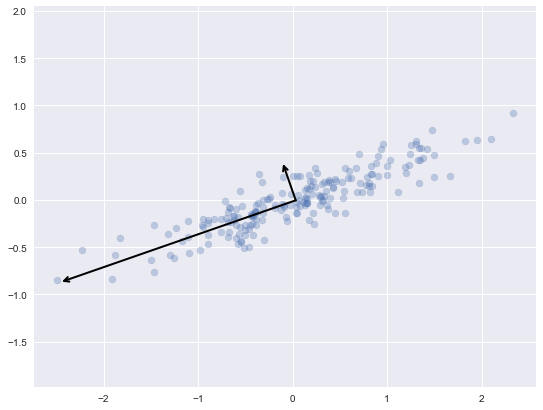

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], alpha=0.3)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal')
plt.show()

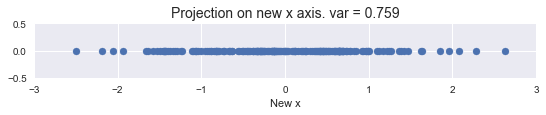

In [19]:
# project over max var axis
# dot product with eigenvector

X_new = X.dot(pca.components_)
var = np.var(X_new[:,0])

fig, ax = plt.subplots(figsize=(9,1))
ax.scatter(X_new[:,0], [0]*X_new.shape[0])
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-3, 3)
ax.set_xlabel('New x')
plt.title(f'Projection on new x axis. var = {var:.3}', fontsize=14)
#ax.set_axis_off()
plt.show()

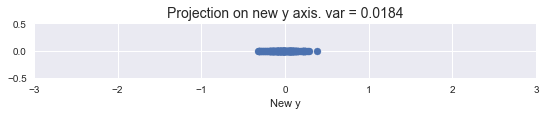

In [20]:
var = np.var(X_new[:,1])

fig, ax = plt.subplots(figsize=(9,1))
ax.scatter(X_new[:,1], [0]*X_new.shape[0])
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-3, 3)
ax.set_xlabel('New y')
plt.title(f'Projection on new y axis. var = {var:.3}', fontsize=14)
#ax.set_axis_off()
plt.show()

* New projection into the new basis maximizes the variance.
* We have reduced from 2 dimensions to 1 dimension.
* These new axes are the **Principal Components**

## Why we want to do PCA?

* Reduce the number of dimensions to new feature space that is more informative.
* Filter noise (raise the signal-to-noise ratio)
* Compress the data. 

## How to build a PCA


### 1. Center the data:

$$ X_{centered}= X - \mu $$

where $\mu$ is the mean of the dataset.
Depending on the nature of the measure, divide by the variance.

Or use the `StandardScaler` from sklearn:
```python 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
```

### 2.  Build the covariance matrix

Imagine we have two measures:
+ $A = \{a_1, a_2,\dots,a_n\}$
+ $B = \{b_1, b_2,\dots,b_n\}$

the variance ($var$ or $\sigma^2$) of one measure is:
$$ var_A = \frac{1}{n-1} \sum_i a_i^2$$

The covariance of $A$ and $B$ simply is:
$$var_{AB} = \frac{1}{n} \sum_i a_i b_i$$ 

And the generalization to an arbitrary number of dimensions is, for a matrix $X$:
$$ C_X = \frac{1}{n} X · X^T $$

or simply do:
```python
numpy.cov(X)
# or:
pandas.DataFrame.cov()
```

In [21]:
import pandas as pd
iris = sns.load_dataset('iris')
iris_labels = iris['species']
iris = iris.drop('species', axis=1)

#### Covariance example with the iris dataset:

In [22]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [23]:
iris.cov()

,sepal_length,sepal_width,petal_length,petal_width
sepal_length,0.685694,-0.042434,1.274315,0.516271
sepal_width,-0.042434,0.189979,-0.329656,-0.121639
petal_length,1.274315,-0.329656,3.116278,1.295609
petal_width,0.516271,-0.121639,1.295609,0.581006


where the diagonal is the variance of every feature and the outer values the covariance.

Note that the covariance matrix is always going to be a square matrix $d \times d$, being $d$ the number of dimensions or features.

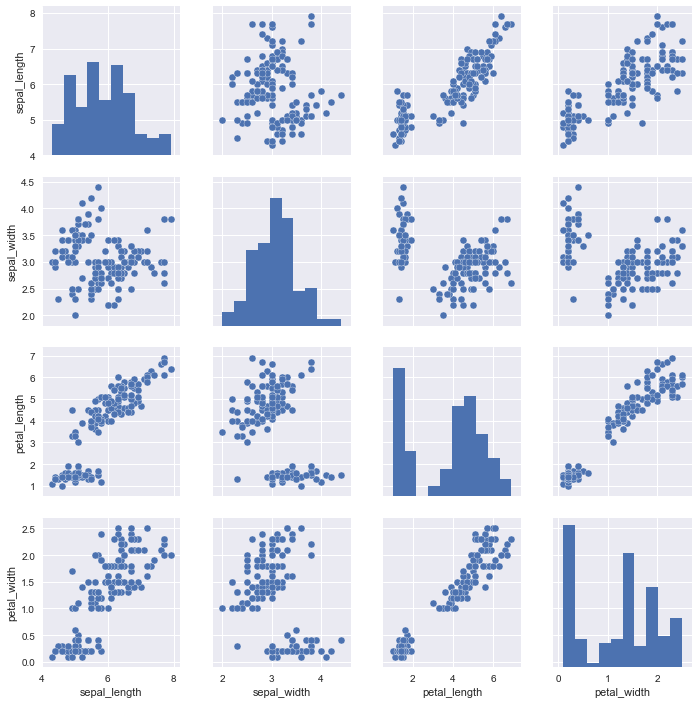

In [24]:
sns.pairplot(iris)

### 3. Build the projection into the principal components.

Via eigendecomposition of the covariance matrix:

given a square covariance matrix $\Sigma$, the eigenvalues and eigenvectors of $\Sigma$ the ones that satisfy:

$$ \Sigma \mathbf{\upsilon} = \lambda \mathbf{\upsilon}$$

The eigenvectors of the covariance matrix represent the **principal components (the directions of maximum variance)**, whereas the corresponding eigenvalues will define their magnitude.

In the case of the Iris dataset:
+ 4 eigenvectors and eigenvalues from the 4x4 cov matrix

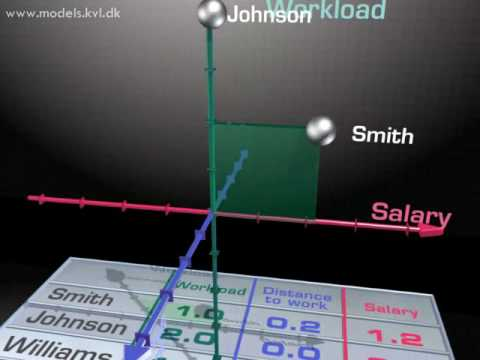

In [25]:
from IPython.display import YouTubeVideo
YouTubeVideo("4pnQd6jnCWk")

## How to compute PCA with scikit-learn

In [26]:
# 1. Import PCA from sklearn.decomposition
from sklearn.decomposition import PCA

In [27]:
# 2. fit an instance of the PCA class to the data
pca = PCA()
pca.fit_transform(X)

array([[ 6.76769235e-01,  5.97386015e-02],
       [-1.07121393e+00,  2.57240064e-01],
       [ 7.27912364e-01, -1.68669939e-01],
       [ 2.30964136e+00,  2.44066575e-01],
       [ 6.30052323e-01, -3.04655713e-01],
       [ 1.02448887e+00,  7.56230140e-02],
       [ 7.77183507e-01, -8.34608477e-02],
       [-1.39656414e+00,  1.44518385e-01],
       [-2.91049874e-01, -2.01289478e-01],
       [ 1.88864221e+00,  2.31419563e-01],
       [-7.11544293e-01,  1.13426118e-01],
       [ 6.38884130e-01,  3.88212853e-02],
       [ 5.48059617e-01, -2.00775267e-01],
       [-2.19312436e-01,  2.08243673e-01],
       [-3.87789490e-01,  6.89135848e-02],
       [ 7.15219956e-01,  1.13841003e-01],
       [-1.08373816e+00,  7.78081042e-02],
       [-2.99917403e-01, -5.86382919e-02],
       [-7.96849021e-01,  2.44527383e-01],
       [-8.12568346e-01, -1.17341246e-01],
       [-1.54018281e+00, -3.24862050e-02],
       [-2.52920476e-01, -4.86012463e-02],
       [ 6.26464454e-01, -1.68045678e-01],
       [-1.